In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

# 스마트카드 데이터
SMART_CARD = pd.read_csv('./data/SMART_CARD.csv', header = None)

# 공공데이터포털
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0) # 전체 노선 기본정보 조회
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0) # 전체노선별경유정류소 정보 조회

# 정류장 데이터
bus_sttn = pd.read_csv('./data/bus_sttn.csv')

In [2]:
def smart_card_data_preprocessing(exdata):
    exdata.columns = ['SERIAL_NO', 'CARD_NO', 'GETON_YMD', 'GETON_TM', 'BUS_ROUTE_ID', 'BUS_CO_ID', 'BUS_CAR_ID', 'GETON_BUS_STTN_ID', 'GETOFF_BUS_STTN_ID',
                        'DRVR_ID', 'TRANSACTION_ID', 'TR_MEANS_TYPE', 'USR_TYPE', 'DRVN_START_YMD', 'DRVN_START_TM', 'GETOFF_YMD', 'GETOFF_TM', 'GETON_CALC_YMD',
                        'GETOFF_CALC_YMD', 'GETON_PAY', 'GETOFF_PAY', 'TRANSF_CNT', 'USR_CNT']
    exdata.drop(labels = ['SERIAL_NO', 'DRVR_ID','TRANSACTION_ID','USR_TYPE','DRVN_START_YMD','BUS_CO_ID','DRVN_START_TM','GETOFF_YMD','GETOFF_TM','GETON_CALC_YMD','GETOFF_CALC_YMD', 'GETON_PAY','GETOFF_PAY','TRANSF_CNT','GETOFF_BUS_STTN_ID'], axis = 1, inplace = True)


    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기

    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')

    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day
    exdata['WEEKDAY'] = exdata['GETON_DATETIME'].dt.weekday  

    # 급행/지선/간선만 필터링
    exdata = exdata[exdata['TR_MEANS_TYPE'].isin([675,676])]

    # 도시 노선만 사용하기 위해
    values_to_remove = [30300147, 30300148, 30300141, 30300137, 30300149, 30300103]
    exdata = exdata[~exdata['BUS_ROUTE_ID'].isin(values_to_remove)]

    # 평일만 추출
    weekday_values = [0, 1, 2, 3, 4]
    exdata = exdata[exdata['WEEKDAY'].isin(weekday_values)]

    # 6/6일 제거
    exdata = exdata[exdata['DAY'] != 6]

    # 비가 온 날 제거
    exdata = exdata[~exdata['DAY'].isin([26,29])]

    # 여러명이 탄 경우 제거
    exdata = exdata[exdata['USR_CNT']==1]

    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','TR_MEANS_TYPE','USR_CNT','WEEKDAY'], axis = 1, inplace = True)
    
    return exdata

In [3]:
SMART_CARD_DATA = smart_card_data_preprocessing(SMART_CARD)

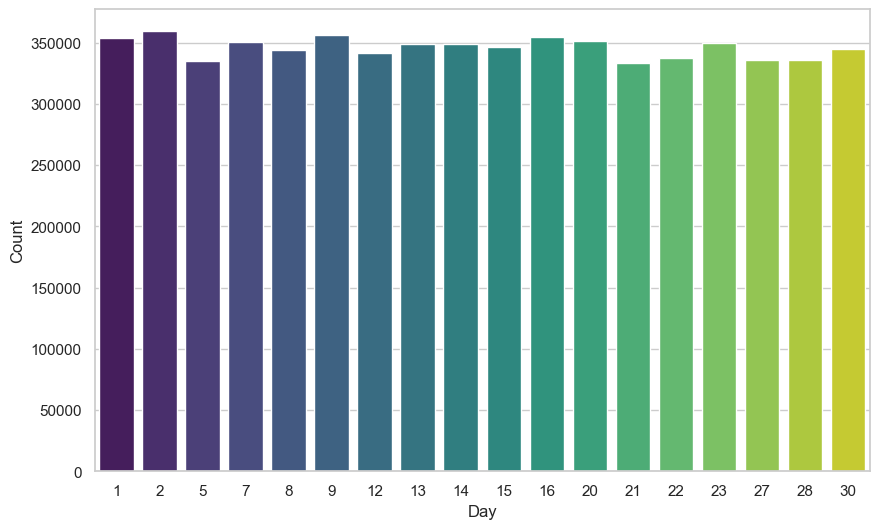

In [21]:
import seaborn as sns
# 일별 이용량 계산
daily_usage = SMART_CARD_DATA.groupby('DAY').size().reset_index(name='COUNT')

# 시각화
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x='DAY', y='COUNT', data=daily_usage, palette="viridis")
plt.title('일별 승차량')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

In [116]:
SMART_CARD_DATA_01 = SMART_CARD_DATA[SMART_CARD_DATA['DAY']==1]
SMART_CARD_DATA_01.head(2)

,CARD_NO,BUS_ROUTE_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,DAY
3,804099084,30300053,130752377,8005978,2023-06-01 05:20:33,1
35,929954937,30300043,130759616,8001243,2023-06-01 05:30:22,1


In [103]:
# # 사용하지 않는 버스를 사용많이하는 버스로 옮기자? 노선 조정?
# 102번 버스 ㅁㄴ읾ㄴ어림ㅇㄹㄴ
# 638번 버스 이용량 -> 102번 ?

# 많은 것부터 ㄱ하고

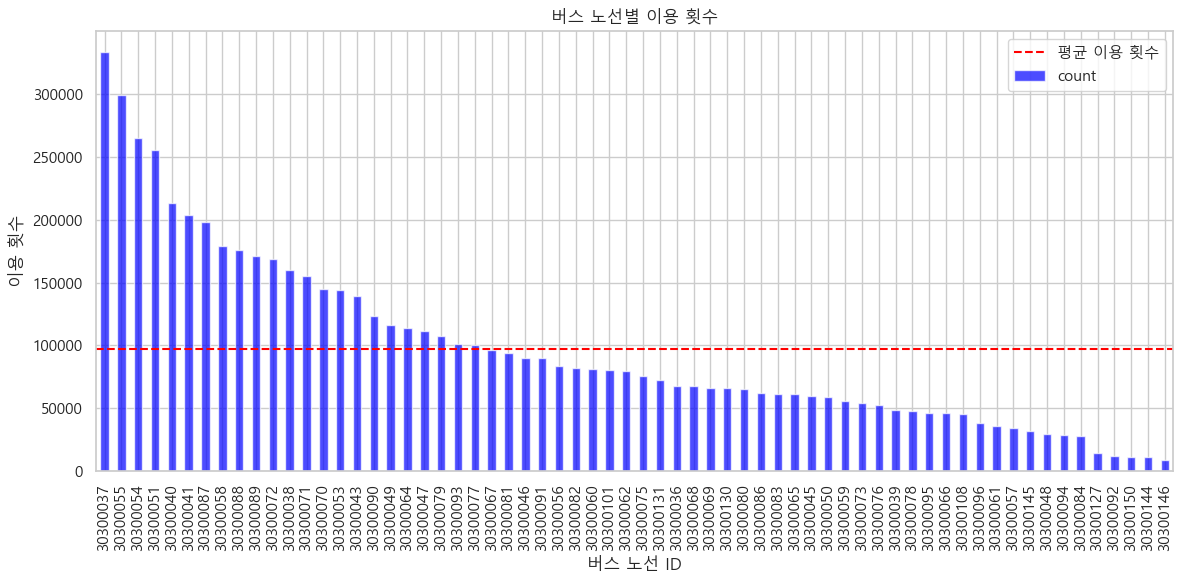

In [117]:
import matplotlib.pyplot as plt

# 버스 노선별 이용 횟수
route_id = SMART_CARD_DATA['BUS_ROUTE_ID'].value_counts()

plt.figure(figsize=(12, 6))
route_id.plot(kind='bar', color='blue', alpha=0.7)
plt.axhline(y=SMART_CARD_DATA['BUS_ROUTE_ID'].value_counts().mean(), color='red', linestyle='--', label='평균 이용 횟수')
plt.xlabel('버스 노선 ID')
plt.ylabel('이용 횟수')
plt.title('버스 노선별 이용 횟수')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [118]:
# 주어진 결과 데이터
bus_series = SMART_CARD_DATA['BUS_ROUTE_ID'].value_counts()[SMART_CARD_DATA['BUS_ROUTE_ID'].value_counts() >= SMART_CARD_DATA['BUS_ROUTE_ID'].value_counts().mean()]

# Series를 데이터프레임으로 변환
filtered_df = bus_series.reset_index()
filtered_df.columns = ['BUS_ROUTE_ID', 'COUNT']
filtered_df

datata = filtered_df.merge(getrouteinfoall[['ROUTE_NO','ROUTE_CD']], left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')

array(['102', '311', '301', '201', '105', '106', '703', '314', '704',
       '705', '605', '103', '604', '603', '211', '108', '706', '119',
       '511', '115', '615', '802', '613'], dtype=object)

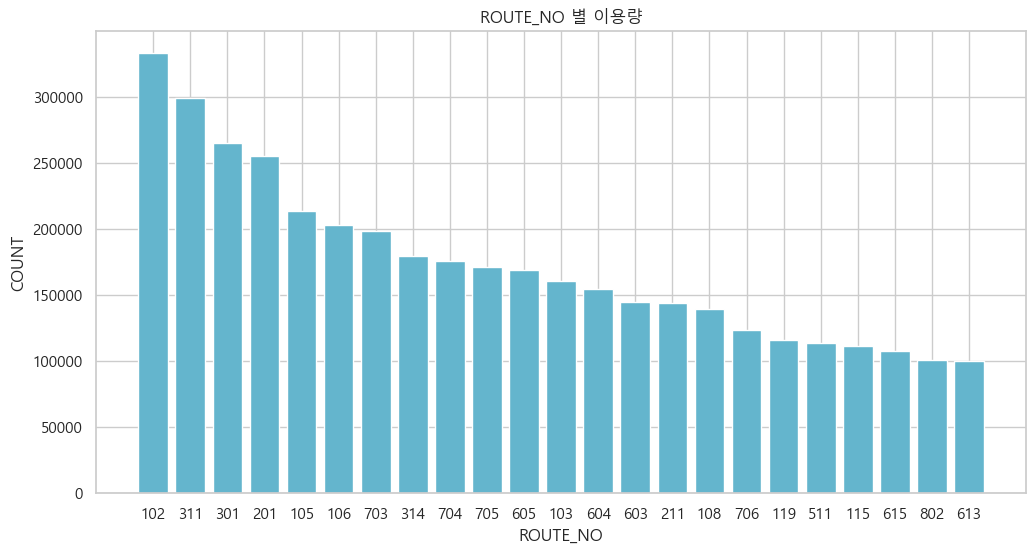

In [126]:
# route_no 별 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(datata['ROUTE_NO'], datata['COUNT'], color='c')  # 색상은 필요에 따라 변경 가능
plt.title('ROUTE_NO 별 이용량')
plt.xlabel('ROUTE_NO')
plt.ylabel('COUNT')
plt.xticks(rotation=0)
plt.show()